# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

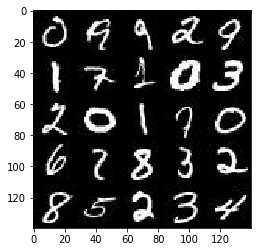

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

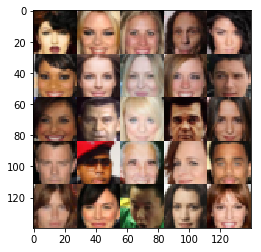

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_img_inputs = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name="real_img_inputs")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name="z_inputs")
    lr = tf.placeholder(tf.float32, name="lr")
    
    return real_img_inputs,z_inputs,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [49]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        #28x28xoutput_dim
        x1 = tf.layers.conv2d(images, 256, 5, strides=2, padding='same')
        x1 = tf.maximum(x1, x1*0.1)
        #14x14x128
        
        x2 = tf.layers.conv2d(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*0.1)
        # 7x7x256
        
        # flatten
        x3 = tf.reshape(x2, (-1,7*7*512))
        logits = tf.layers.dense(x3, 1)
        out = tf.sigmoid(logits)
        

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=(not is_train)):
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(0.1 * x1, x1)

        # 14x14x512
        x2 = tf.layers.conv2d_transpose(x1,256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.1*x2, x2)

        # 28x28xoutput_dim
        x3 = tf.layers.conv2d_transpose(x2,out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(x3)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # get the logits
    gen_out = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(images=input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(images=gen_out, reuse=True)
    
    
    # loss calculations
    labels_real = tf.ones_like(d_out_real)
    labels_fake = tf.zeros_like(d_out_fake)
    labels_generator = tf.ones_like(d_out_fake)
    # discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_fake))
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss 
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_generator))
    

    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_trainable_vars = tf.trainable_variables()
    g_vars = [var for var in all_trainable_vars if var.name.startswith('generator')]
    d_vars = [var for var in all_trainable_vars if var.name.startswith('discriminator')]
    
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    
    """
    # TODO: Build Model
    img_width = data_shape[1]
    img_height = data_shape[2]
    img_channels_count = data_shape[3]
    
    print("Image size ",img_width,"x",img_height,"x",img_channels_count)
    # build model 
    real_img_inputs, z_inputs, lr = model_inputs(img_width, img_height, img_channels_count, z_dim)
    d_loss, g_loss = model_loss(real_img_inputs, z_inputs, img_channels_count)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model

                # generate random noise 
                batch_z = np.random.uniform(-1,1, size=(batch_size,z_dim))
               
                # train discriminator and generator together
                _ = sess.run(d_train_opt, feed_dict={real_img_inputs:batch_images, z_inputs:batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_inputs:batch_z, lr:learning_rate, real_img_inputs:batch_images})
                
                # now print loss every 100 iteration
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_inputs:batch_z,real_img_inputs:batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})
                    
                    print("Epoch ",epoch_i,
                          " ... Discri.Loss: ", train_loss_d, 
                          " Generator loss: ", train_loss_g )
                if steps % 100 == 0:    
                    show_generator_output(sess, 16, z_inputs, img_channels_count, data_image_mode)
        
        saver.save(sess, './saved_data.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Image size  28 x 28 x 1
Epoch  0  ... Discri.Loss:  2.06402  Generator loss:  0.143117
Epoch  0  ... Discri.Loss:  0.002927  Generator loss:  6.27898
Epoch  0  ... Discri.Loss:  9.18518  Generator loss:  0.000192587
Epoch  0  ... Discri.Loss:  0.00440814  Generator loss:  6.23389
Epoch  0  ... Discri.Loss:  1.65015  Generator loss:  0.819725
Epoch  0  ... Discri.Loss:  0.00997987  Generator loss:  5.77068
Epoch  0  ... Discri.Loss:  3.80306  Generator loss:  0.484381
Epoch  0  ... Discri.Loss:  0.154897  Generator loss:  2.90628
Epoch  0  ... Discri.Loss:  0.237067  Generator loss:  2.44817
Epoch  0  ... Discri.Loss:  0.35964  Generator loss:  2.26053


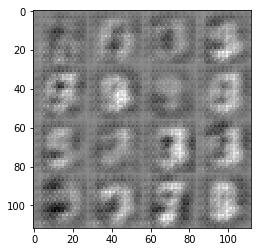

Epoch  0  ... Discri.Loss:  0.454945  Generator loss:  3.52898
Epoch  0  ... Discri.Loss:  0.242122  Generator loss:  2.37694
Epoch  0  ... Discri.Loss:  0.452194  Generator loss:  1.7445
Epoch  0  ... Discri.Loss:  1.56457  Generator loss:  6.38716
Epoch  0  ... Discri.Loss:  2.0856  Generator loss:  0.202955
Epoch  0  ... Discri.Loss:  0.0335328  Generator loss:  6.68542
Epoch  0  ... Discri.Loss:  0.0591831  Generator loss:  9.48718
Epoch  0  ... Discri.Loss:  0.656539  Generator loss:  6.63329
Epoch  0  ... Discri.Loss:  0.0324032  Generator loss:  4.8898
Epoch  0  ... Discri.Loss:  0.0194155  Generator loss:  6.7345


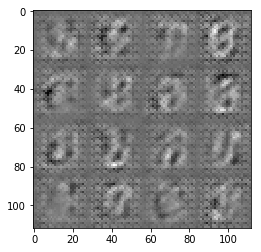

Epoch  0  ... Discri.Loss:  1.06174  Generator loss:  0.971758
Epoch  0  ... Discri.Loss:  1.10558  Generator loss:  0.777682
Epoch  0  ... Discri.Loss:  0.60986  Generator loss:  1.1139
Epoch  0  ... Discri.Loss:  0.459878  Generator loss:  1.49382
Epoch  0  ... Discri.Loss:  1.52765  Generator loss:  0.368945
Epoch  0  ... Discri.Loss:  0.270937  Generator loss:  2.23783
Epoch  0  ... Discri.Loss:  0.620875  Generator loss:  1.31191
Epoch  0  ... Discri.Loss:  0.253027  Generator loss:  5.69462
Epoch  0  ... Discri.Loss:  0.767487  Generator loss:  1.52818
Epoch  0  ... Discri.Loss:  1.64482  Generator loss:  0.287668


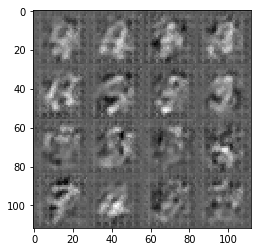

Epoch  0  ... Discri.Loss:  0.592848  Generator loss:  6.43859
Epoch  0  ... Discri.Loss:  0.0537157  Generator loss:  14.9483
Epoch  0  ... Discri.Loss:  0.0734592  Generator loss:  6.57548
Epoch  0  ... Discri.Loss:  0.725776  Generator loss:  2.89605
Epoch  0  ... Discri.Loss:  0.23961  Generator loss:  11.0656
Epoch  0  ... Discri.Loss:  0.0805075  Generator loss:  8.86235
Epoch  0  ... Discri.Loss:  0.100296  Generator loss:  6.30292
Epoch  0  ... Discri.Loss:  0.755785  Generator loss:  0.769309
Epoch  0  ... Discri.Loss:  1.08098  Generator loss:  0.555699
Epoch  0  ... Discri.Loss:  0.0973278  Generator loss:  3.36509


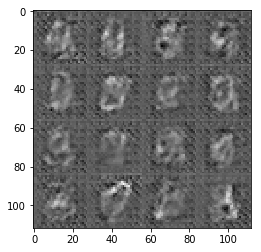

Epoch  0  ... Discri.Loss:  0.36314  Generator loss:  1.79276
Epoch  0  ... Discri.Loss:  1.02286  Generator loss:  0.589362
Epoch  0  ... Discri.Loss:  0.594113  Generator loss:  2.32634
Epoch  0  ... Discri.Loss:  0.340246  Generator loss:  1.74329
Epoch  0  ... Discri.Loss:  0.124926  Generator loss:  2.63977
Epoch  0  ... Discri.Loss:  0.926481  Generator loss:  0.60937
Epoch  0  ... Discri.Loss:  0.0881101  Generator loss:  4.74319
Epoch  0  ... Discri.Loss:  0.730206  Generator loss:  0.881714
Epoch  0  ... Discri.Loss:  0.167411  Generator loss:  5.24016
Epoch  0  ... Discri.Loss:  0.0428758  Generator loss:  4.15855


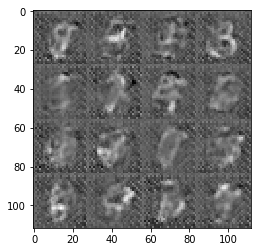

Epoch  0  ... Discri.Loss:  0.103773  Generator loss:  7.96627
Epoch  0  ... Discri.Loss:  0.473258  Generator loss:  4.39395
Epoch  0  ... Discri.Loss:  1.03652  Generator loss:  0.639983
Epoch  0  ... Discri.Loss:  0.797973  Generator loss:  0.802608
Epoch  0  ... Discri.Loss:  0.0731464  Generator loss:  4.7445
Epoch  0  ... Discri.Loss:  0.425317  Generator loss:  1.40808
Epoch  0  ... Discri.Loss:  0.107944  Generator loss:  3.16511
Epoch  0  ... Discri.Loss:  0.00983683  Generator loss:  7.5553
Epoch  0  ... Discri.Loss:  0.338527  Generator loss:  1.60857
Epoch  0  ... Discri.Loss:  0.215187  Generator loss:  2.0112


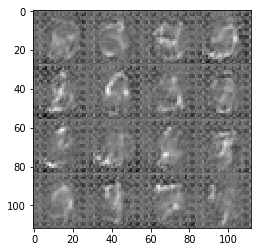

Epoch  0  ... Discri.Loss:  0.233628  Generator loss:  1.90218
Epoch  0  ... Discri.Loss:  0.036569  Generator loss:  5.70778
Epoch  0  ... Discri.Loss:  0.0614647  Generator loss:  3.35325
Epoch  0  ... Discri.Loss:  0.0174763  Generator loss:  11.272
Epoch  0  ... Discri.Loss:  0.015756  Generator loss:  8.83178
Epoch  0  ... Discri.Loss:  0.0248565  Generator loss:  4.39759
Epoch  0  ... Discri.Loss:  0.0392767  Generator loss:  8.79469
Epoch  0  ... Discri.Loss:  2.34556  Generator loss:  0.220778
Epoch  0  ... Discri.Loss:  0.811025  Generator loss:  1.78918
Epoch  0  ... Discri.Loss:  0.747213  Generator loss:  3.6225


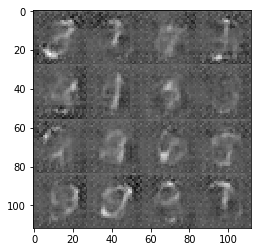

Epoch  0  ... Discri.Loss:  0.35233  Generator loss:  1.74566
Epoch  0  ... Discri.Loss:  0.3124  Generator loss:  1.88389
Epoch  0  ... Discri.Loss:  0.1814  Generator loss:  2.33188
Epoch  0  ... Discri.Loss:  0.309346  Generator loss:  1.7385
Epoch  0  ... Discri.Loss:  0.154955  Generator loss:  2.56197
Epoch  0  ... Discri.Loss:  0.16554  Generator loss:  2.79977
Epoch  0  ... Discri.Loss:  0.300826  Generator loss:  1.71312
Epoch  0  ... Discri.Loss:  0.460193  Generator loss:  1.41527
Epoch  0  ... Discri.Loss:  0.0455996  Generator loss:  5.02507
Epoch  0  ... Discri.Loss:  0.0144031  Generator loss:  7.53145


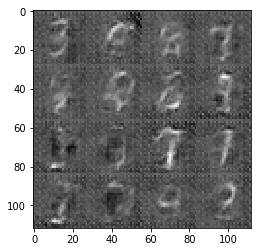

Epoch  0  ... Discri.Loss:  2.25487  Generator loss:  0.337631
Epoch  0  ... Discri.Loss:  4.45214  Generator loss:  0.0854939
Epoch  0  ... Discri.Loss:  0.6085  Generator loss:  1.35747
Epoch  0  ... Discri.Loss:  0.536154  Generator loss:  1.87508
Epoch  0  ... Discri.Loss:  0.315071  Generator loss:  1.71178
Epoch  0  ... Discri.Loss:  0.235572  Generator loss:  1.94231
Epoch  0  ... Discri.Loss:  0.13668  Generator loss:  2.69022
Epoch  0  ... Discri.Loss:  0.117343  Generator loss:  3.08402
Epoch  0  ... Discri.Loss:  0.050637  Generator loss:  5.24588
Epoch  0  ... Discri.Loss:  0.0383172  Generator loss:  8.27824


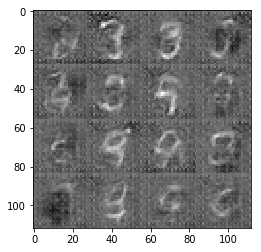

Epoch  0  ... Discri.Loss:  0.12664  Generator loss:  3.16245
Epoch  0  ... Discri.Loss:  0.399088  Generator loss:  1.37955
Epoch  0  ... Discri.Loss:  0.0882211  Generator loss:  3.98069
Epoch  0  ... Discri.Loss:  0.051805  Generator loss:  3.92813
Epoch  0  ... Discri.Loss:  0.0259129  Generator loss:  5.18597
Epoch  0  ... Discri.Loss:  0.0967795  Generator loss:  3.30868
Epoch  0  ... Discri.Loss:  0.177294  Generator loss:  2.64674
Epoch  0  ... Discri.Loss:  0.233866  Generator loss:  1.89581
Epoch  0  ... Discri.Loss:  0.151679  Generator loss:  2.43536
Epoch  0  ... Discri.Loss:  0.0450069  Generator loss:  7.86748


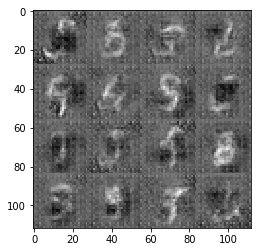

Epoch  0  ... Discri.Loss:  0.98972  Generator loss:  0.829633
Epoch  0  ... Discri.Loss:  0.0749873  Generator loss:  9.00345
Epoch  0  ... Discri.Loss:  0.0173085  Generator loss:  6.34748
Epoch  0  ... Discri.Loss:  0.0484704  Generator loss:  9.04067
Epoch  0  ... Discri.Loss:  0.00747459  Generator loss:  8.61541
Epoch  0  ... Discri.Loss:  0.0215584  Generator loss:  6.0526
Epoch  0  ... Discri.Loss:  0.0121712  Generator loss:  8.06925
Epoch  0  ... Discri.Loss:  0.471185  Generator loss:  1.31677
Epoch  0  ... Discri.Loss:  0.0106515  Generator loss:  10.3766
Epoch  0  ... Discri.Loss:  0.0136239  Generator loss:  11.0386


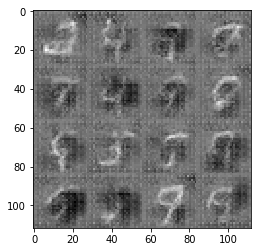

Epoch  0  ... Discri.Loss:  0.0838564  Generator loss:  3.38043
Epoch  0  ... Discri.Loss:  0.377478  Generator loss:  1.55839
Epoch  0  ... Discri.Loss:  0.0297835  Generator loss:  4.70898
Epoch  0  ... Discri.Loss:  2.73577  Generator loss:  5.98067
Epoch  0  ... Discri.Loss:  2.67311  Generator loss:  0.194532
Epoch  0  ... Discri.Loss:  0.163261  Generator loss:  3.10136
Epoch  0  ... Discri.Loss:  0.374648  Generator loss:  1.58036
Epoch  0  ... Discri.Loss:  0.790959  Generator loss:  1.02963
Epoch  0  ... Discri.Loss:  0.883898  Generator loss:  0.904238
Epoch  0  ... Discri.Loss:  1.07295  Generator loss:  4.46946


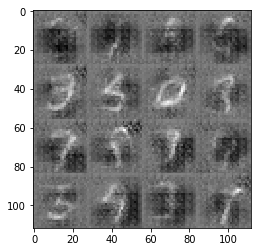

Epoch  0  ... Discri.Loss:  0.423931  Generator loss:  1.43826
Epoch  0  ... Discri.Loss:  0.200992  Generator loss:  2.33165
Epoch  0  ... Discri.Loss:  0.151678  Generator loss:  2.62949
Epoch  0  ... Discri.Loss:  0.112194  Generator loss:  2.54872
Epoch  0  ... Discri.Loss:  0.490724  Generator loss:  1.23055
Epoch  0  ... Discri.Loss:  0.226559  Generator loss:  2.30155
Epoch  0  ... Discri.Loss:  0.125208  Generator loss:  3.14262
Epoch  0  ... Discri.Loss:  0.0972009  Generator loss:  2.86449
Epoch  0  ... Discri.Loss:  0.014042  Generator loss:  5.76807
Epoch  0  ... Discri.Loss:  0.333571  Generator loss:  2.13324


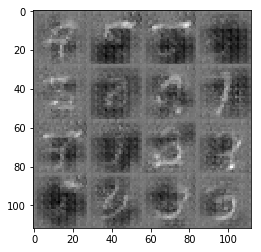

Epoch  0  ... Discri.Loss:  0.111614  Generator loss:  3.49003
Epoch  0  ... Discri.Loss:  0.077658  Generator loss:  3.42637
Epoch  0  ... Discri.Loss:  0.0647629  Generator loss:  3.75447
Epoch  0  ... Discri.Loss:  0.143309  Generator loss:  2.70006
Epoch  0  ... Discri.Loss:  0.0727905  Generator loss:  3.52272
Epoch  0  ... Discri.Loss:  0.0503895  Generator loss:  9.95004
Epoch  0  ... Discri.Loss:  0.147544  Generator loss:  2.71645
Epoch  0  ... Discri.Loss:  0.0403434  Generator loss:  4.02185
Epoch  0  ... Discri.Loss:  0.031616  Generator loss:  6.31499
Epoch  0  ... Discri.Loss:  0.00790573  Generator loss:  8.23511


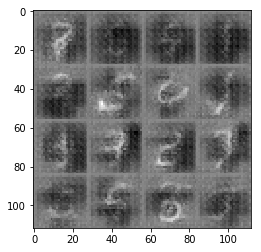

Epoch  0  ... Discri.Loss:  0.146864  Generator loss:  4.09569
Epoch  0  ... Discri.Loss:  0.0236809  Generator loss:  9.45626
Epoch  0  ... Discri.Loss:  0.0337067  Generator loss:  4.61871
Epoch  0  ... Discri.Loss:  0.0950679  Generator loss:  3.88181
Epoch  0  ... Discri.Loss:  0.0869937  Generator loss:  3.09443
Epoch  0  ... Discri.Loss:  0.0380173  Generator loss:  11.0681
Epoch  0  ... Discri.Loss:  0.299869  Generator loss:  1.82286
Epoch  0  ... Discri.Loss:  0.00742621  Generator loss:  8.96972
Epoch  0  ... Discri.Loss:  0.00584892  Generator loss:  11.6846
Epoch  0  ... Discri.Loss:  0.0265734  Generator loss:  9.11719


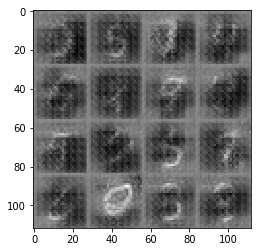

Epoch  0  ... Discri.Loss:  0.021812  Generator loss:  6.10021
Epoch  0  ... Discri.Loss:  0.00968792  Generator loss:  13.1593
Epoch  0  ... Discri.Loss:  0.0380062  Generator loss:  4.15661
Epoch  0  ... Discri.Loss:  0.0162372  Generator loss:  6.06306
Epoch  0  ... Discri.Loss:  0.0180811  Generator loss:  8.1258
Epoch  0  ... Discri.Loss:  0.171992  Generator loss:  2.46936
Epoch  0  ... Discri.Loss:  0.0107591  Generator loss:  6.98205
Epoch  0  ... Discri.Loss:  0.00582198  Generator loss:  6.79663
Epoch  0  ... Discri.Loss:  0.0157605  Generator loss:  6.10264
Epoch  0  ... Discri.Loss:  0.0134002  Generator loss:  7.61986


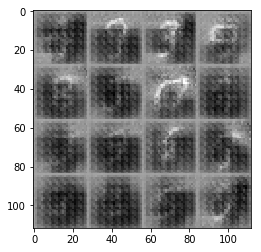

Epoch  0  ... Discri.Loss:  0.0328439  Generator loss:  4.8968
Epoch  0  ... Discri.Loss:  0.317275  Generator loss:  3.42066
Epoch  0  ... Discri.Loss:  1.36367  Generator loss:  6.74853
Epoch  0  ... Discri.Loss:  2.45915  Generator loss:  0.249837
Epoch  0  ... Discri.Loss:  0.463067  Generator loss:  1.91153
Epoch  0  ... Discri.Loss:  0.600191  Generator loss:  3.65703
Epoch  0  ... Discri.Loss:  0.594724  Generator loss:  1.03926
Epoch  0  ... Discri.Loss:  0.172951  Generator loss:  2.88873
Epoch  0  ... Discri.Loss:  0.258096  Generator loss:  2.40973
Epoch  0  ... Discri.Loss:  0.225541  Generator loss:  2.28162


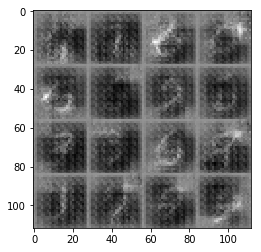

Epoch  0  ... Discri.Loss:  0.085059  Generator loss:  3.44742
Epoch  0  ... Discri.Loss:  0.101077  Generator loss:  3.30693
Epoch  0  ... Discri.Loss:  0.146579  Generator loss:  2.99038
Epoch  0  ... Discri.Loss:  0.110821  Generator loss:  2.99773
Epoch  0  ... Discri.Loss:  1.09517  Generator loss:  0.73491
Epoch  0  ... Discri.Loss:  0.366292  Generator loss:  2.60472
Epoch  0  ... Discri.Loss:  0.25648  Generator loss:  2.98765
Epoch  0  ... Discri.Loss:  0.355946  Generator loss:  1.82869
Epoch  0  ... Discri.Loss:  0.329713  Generator loss:  1.62935
Epoch  0  ... Discri.Loss:  0.252211  Generator loss:  2.08827


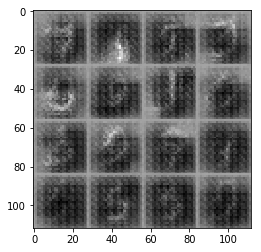

Epoch  0  ... Discri.Loss:  0.138865  Generator loss:  3.32627
Epoch  0  ... Discri.Loss:  0.0952222  Generator loss:  3.13538
Epoch  0  ... Discri.Loss:  4.74257  Generator loss:  0.0467057
Epoch  0  ... Discri.Loss:  0.554493  Generator loss:  2.87041
Epoch  0  ... Discri.Loss:  0.306613  Generator loss:  2.15985
Epoch  0  ... Discri.Loss:  0.99325  Generator loss:  0.652679
Epoch  0  ... Discri.Loss:  0.189414  Generator loss:  2.63942
Epoch  1  ... Discri.Loss:  0.13332  Generator loss:  3.03164
Epoch  1  ... Discri.Loss:  0.250485  Generator loss:  3.64375
Epoch  1  ... Discri.Loss:  0.292463  Generator loss:  1.89725


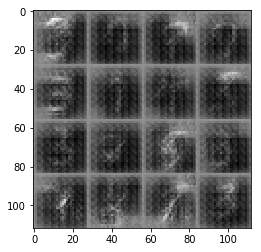

Epoch  1  ... Discri.Loss:  0.17572  Generator loss:  2.43157
Epoch  1  ... Discri.Loss:  0.0297956  Generator loss:  7.54295
Epoch  1  ... Discri.Loss:  0.113652  Generator loss:  5.63074
Epoch  1  ... Discri.Loss:  0.0421689  Generator loss:  4.45821
Epoch  1  ... Discri.Loss:  0.115095  Generator loss:  6.41218
Epoch  1  ... Discri.Loss:  0.0648276  Generator loss:  5.48005
Epoch  1  ... Discri.Loss:  0.403136  Generator loss:  1.68814
Epoch  1  ... Discri.Loss:  0.00930073  Generator loss:  8.5583
Epoch  1  ... Discri.Loss:  0.00733984  Generator loss:  8.23804
Epoch  1  ... Discri.Loss:  0.0235482  Generator loss:  5.31303


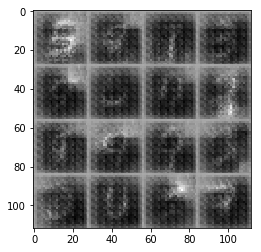

Epoch  1  ... Discri.Loss:  0.41422  Generator loss:  1.82372
Epoch  1  ... Discri.Loss:  0.00980191  Generator loss:  8.16724
Epoch  1  ... Discri.Loss:  0.0871621  Generator loss:  3.16193
Epoch  1  ... Discri.Loss:  0.0113294  Generator loss:  8.7164
Epoch  1  ... Discri.Loss:  0.00927877  Generator loss:  8.57518
Epoch  1  ... Discri.Loss:  0.0464612  Generator loss:  3.82705
Epoch  1  ... Discri.Loss:  0.0276048  Generator loss:  4.87178
Epoch  1  ... Discri.Loss:  0.0361417  Generator loss:  10.1478
Epoch  1  ... Discri.Loss:  0.933806  Generator loss:  2.65013
Epoch  1  ... Discri.Loss:  1.4776  Generator loss:  6.32064


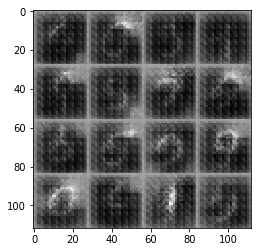

Epoch  1  ... Discri.Loss:  0.410412  Generator loss:  1.47388
Epoch  1  ... Discri.Loss:  0.257961  Generator loss:  2.66619
Epoch  1  ... Discri.Loss:  0.555521  Generator loss:  1.18243
Epoch  1  ... Discri.Loss:  0.203572  Generator loss:  2.81261
Epoch  1  ... Discri.Loss:  0.2616  Generator loss:  2.60681
Epoch  1  ... Discri.Loss:  0.233179  Generator loss:  2.12394
Epoch  1  ... Discri.Loss:  0.0810052  Generator loss:  3.43621
Epoch  1  ... Discri.Loss:  0.209342  Generator loss:  2.30397
Epoch  1  ... Discri.Loss:  0.0649538  Generator loss:  3.53827
Epoch  1  ... Discri.Loss:  0.0886679  Generator loss:  3.38201


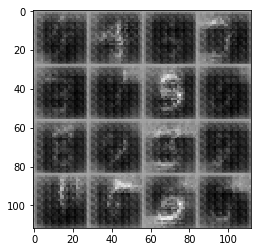

Epoch  1  ... Discri.Loss:  0.101141  Generator loss:  4.40875
Epoch  1  ... Discri.Loss:  0.131245  Generator loss:  2.83411
Epoch  1  ... Discri.Loss:  0.039829  Generator loss:  4.77713
Epoch  1  ... Discri.Loss:  0.18088  Generator loss:  2.41128
Epoch  1  ... Discri.Loss:  0.158966  Generator loss:  2.60368
Epoch  1  ... Discri.Loss:  0.157626  Generator loss:  2.31737
Epoch  1  ... Discri.Loss:  0.232927  Generator loss:  2.51069
Epoch  1  ... Discri.Loss:  0.0204412  Generator loss:  6.72027
Epoch  1  ... Discri.Loss:  0.0164169  Generator loss:  5.86536
Epoch  1  ... Discri.Loss:  0.0662751  Generator loss:  4.66987


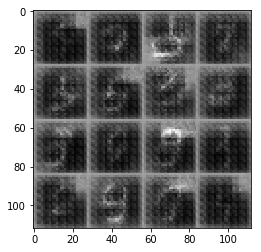

Epoch  1  ... Discri.Loss:  0.00958732  Generator loss:  6.99573
Epoch  1  ... Discri.Loss:  0.0227335  Generator loss:  6.6277
Epoch  1  ... Discri.Loss:  0.0303176  Generator loss:  6.41249
Epoch  1  ... Discri.Loss:  0.0432681  Generator loss:  5.62071
Epoch  1  ... Discri.Loss:  0.0633011  Generator loss:  4.09689
Epoch  1  ... Discri.Loss:  0.197035  Generator loss:  2.49842
Epoch  1  ... Discri.Loss:  0.0254484  Generator loss:  5.04042
Epoch  1  ... Discri.Loss:  0.0630939  Generator loss:  3.92967
Epoch  1  ... Discri.Loss:  0.0845979  Generator loss:  3.36381
Epoch  1  ... Discri.Loss:  0.00376949  Generator loss:  7.76421


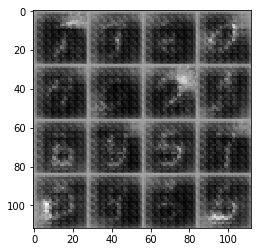

Epoch  1  ... Discri.Loss:  0.117641  Generator loss:  3.38927
Epoch  1  ... Discri.Loss:  0.00764072  Generator loss:  6.40805
Epoch  1  ... Discri.Loss:  0.162772  Generator loss:  3.09863
Epoch  1  ... Discri.Loss:  0.268967  Generator loss:  2.04417
Epoch  1  ... Discri.Loss:  0.779061  Generator loss:  7.33653
Epoch  1  ... Discri.Loss:  1.05889  Generator loss:  4.14379
Epoch  1  ... Discri.Loss:  0.868474  Generator loss:  0.962035
Epoch  1  ... Discri.Loss:  0.479177  Generator loss:  2.16823
Epoch  1  ... Discri.Loss:  0.455623  Generator loss:  4.43917
Epoch  1  ... Discri.Loss:  0.292576  Generator loss:  1.95604


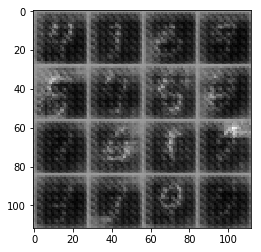

Epoch  1  ... Discri.Loss:  0.211776  Generator loss:  2.09341
Epoch  1  ... Discri.Loss:  0.304952  Generator loss:  1.98108
Epoch  1  ... Discri.Loss:  0.301419  Generator loss:  2.02677
Epoch  1  ... Discri.Loss:  0.11991  Generator loss:  3.11035
Epoch  1  ... Discri.Loss:  0.08175  Generator loss:  3.29461
Epoch  1  ... Discri.Loss:  1.00938  Generator loss:  7.33998
Epoch  1  ... Discri.Loss:  0.629522  Generator loss:  1.17143
Epoch  1  ... Discri.Loss:  0.139283  Generator loss:  3.23786
Epoch  1  ... Discri.Loss:  0.101178  Generator loss:  3.33008
Epoch  1  ... Discri.Loss:  0.0888931  Generator loss:  3.24576


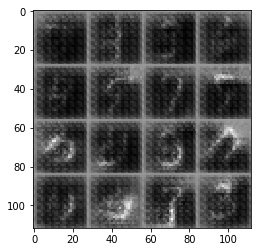

Epoch  1  ... Discri.Loss:  0.232517  Generator loss:  2.32085
Epoch  1  ... Discri.Loss:  0.033625  Generator loss:  4.54352
Epoch  1  ... Discri.Loss:  0.0864402  Generator loss:  3.3892
Epoch  1  ... Discri.Loss:  0.0579489  Generator loss:  3.86012
Epoch  1  ... Discri.Loss:  0.104738  Generator loss:  3.31544
Epoch  1  ... Discri.Loss:  0.108736  Generator loss:  3.4371
Epoch  1  ... Discri.Loss:  0.256702  Generator loss:  2.40707
Epoch  1  ... Discri.Loss:  0.0473213  Generator loss:  4.68791
Epoch  1  ... Discri.Loss:  0.0649969  Generator loss:  4.20406
Epoch  1  ... Discri.Loss:  0.20725  Generator loss:  2.21185


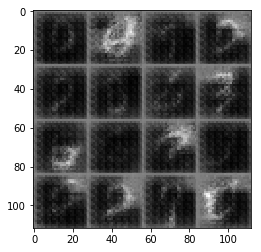

Epoch  1  ... Discri.Loss:  0.0133139  Generator loss:  7.18946
Epoch  1  ... Discri.Loss:  0.0252637  Generator loss:  4.70393
Epoch  1  ... Discri.Loss:  0.0391703  Generator loss:  4.65042
Epoch  1  ... Discri.Loss:  0.136272  Generator loss:  4.0039
Epoch  1  ... Discri.Loss:  0.0119422  Generator loss:  7.98556
Epoch  1  ... Discri.Loss:  2.30416  Generator loss:  0.240007
Epoch  1  ... Discri.Loss:  0.915222  Generator loss:  1.66987
Epoch  1  ... Discri.Loss:  0.446697  Generator loss:  3.01313
Epoch  1  ... Discri.Loss:  0.634243  Generator loss:  1.64347
Epoch  1  ... Discri.Loss:  0.412879  Generator loss:  2.68952


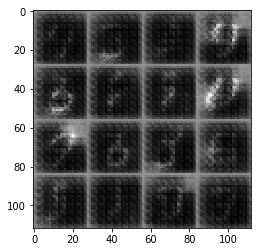

Epoch  1  ... Discri.Loss:  0.366312  Generator loss:  1.746
Epoch  1  ... Discri.Loss:  0.211794  Generator loss:  3.26649
Epoch  1  ... Discri.Loss:  0.177012  Generator loss:  2.70525
Epoch  1  ... Discri.Loss:  0.198991  Generator loss:  2.54474
Epoch  1  ... Discri.Loss:  0.125613  Generator loss:  3.00229
Epoch  1  ... Discri.Loss:  0.0847427  Generator loss:  3.94181
Epoch  1  ... Discri.Loss:  0.0729147  Generator loss:  4.02931
Epoch  1  ... Discri.Loss:  0.0395924  Generator loss:  4.75567
Epoch  1  ... Discri.Loss:  0.0647931  Generator loss:  4.01243
Epoch  1  ... Discri.Loss:  0.104996  Generator loss:  2.72538


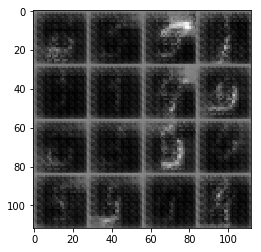

Epoch  1  ... Discri.Loss:  0.0297481  Generator loss:  6.59409
Epoch  1  ... Discri.Loss:  0.0293192  Generator loss:  6.00506
Epoch  1  ... Discri.Loss:  0.0512206  Generator loss:  6.14509
Epoch  1  ... Discri.Loss:  0.0142747  Generator loss:  5.67079
Epoch  1  ... Discri.Loss:  0.0200423  Generator loss:  7.38573
Epoch  1  ... Discri.Loss:  0.0495183  Generator loss:  5.32972
Epoch  1  ... Discri.Loss:  0.166216  Generator loss:  2.65369
Epoch  1  ... Discri.Loss:  0.0487725  Generator loss:  4.04028
Epoch  1  ... Discri.Loss:  0.0318827  Generator loss:  4.21414
Epoch  1  ... Discri.Loss:  0.0194292  Generator loss:  5.49974


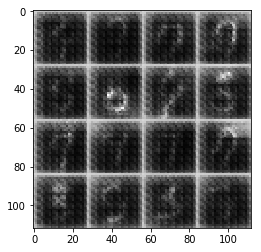

Epoch  1  ... Discri.Loss:  0.263377  Generator loss:  2.13702
Epoch  1  ... Discri.Loss:  0.0765022  Generator loss:  3.44925
Epoch  1  ... Discri.Loss:  0.0187805  Generator loss:  6.22634
Epoch  1  ... Discri.Loss:  0.0129042  Generator loss:  7.07514
Epoch  1  ... Discri.Loss:  0.0335138  Generator loss:  4.82136
Epoch  1  ... Discri.Loss:  0.401263  Generator loss:  2.05233
Epoch  1  ... Discri.Loss:  0.040355  Generator loss:  5.86188
Epoch  1  ... Discri.Loss:  0.00800621  Generator loss:  7.27676
Epoch  1  ... Discri.Loss:  0.0291343  Generator loss:  4.9289
Epoch  1  ... Discri.Loss:  0.0273227  Generator loss:  6.10259


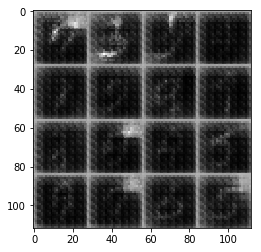

Epoch  1  ... Discri.Loss:  0.121125  Generator loss:  7.80882
Epoch  1  ... Discri.Loss:  0.214805  Generator loss:  2.61426
Epoch  1  ... Discri.Loss:  0.217737  Generator loss:  2.41719
Epoch  1  ... Discri.Loss:  0.0331306  Generator loss:  4.46757
Epoch  1  ... Discri.Loss:  0.378652  Generator loss:  2.06407
Epoch  1  ... Discri.Loss:  0.035825  Generator loss:  4.76655
Epoch  1  ... Discri.Loss:  0.0675142  Generator loss:  3.60807
Epoch  1  ... Discri.Loss:  0.0847049  Generator loss:  3.7133
Epoch  1  ... Discri.Loss:  0.0400693  Generator loss:  4.32295
Epoch  1  ... Discri.Loss:  0.0871183  Generator loss:  3.64422


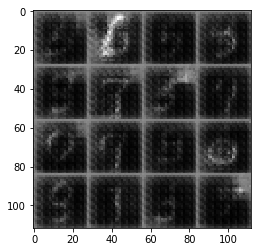

Epoch  1  ... Discri.Loss:  0.306175  Generator loss:  1.91928
Epoch  1  ... Discri.Loss:  0.0183991  Generator loss:  4.87959
Epoch  1  ... Discri.Loss:  0.00915355  Generator loss:  6.23859
Epoch  1  ... Discri.Loss:  0.0663376  Generator loss:  4.03042
Epoch  1  ... Discri.Loss:  0.0337542  Generator loss:  4.64042
Epoch  1  ... Discri.Loss:  0.00697071  Generator loss:  6.16545
Epoch  1  ... Discri.Loss:  0.00697478  Generator loss:  9.05787
Epoch  1  ... Discri.Loss:  0.0323303  Generator loss:  6.99835
Epoch  1  ... Discri.Loss:  0.0712678  Generator loss:  4.70944
Epoch  1  ... Discri.Loss:  0.0252757  Generator loss:  4.8545


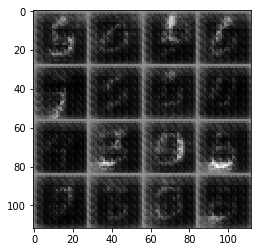

Epoch  1  ... Discri.Loss:  0.00898129  Generator loss:  9.33298
Epoch  1  ... Discri.Loss:  8.06052  Generator loss:  0.0065421
Epoch  1  ... Discri.Loss:  1.91084  Generator loss:  6.84495
Epoch  1  ... Discri.Loss:  0.70333  Generator loss:  2.18705
Epoch  1  ... Discri.Loss:  0.439488  Generator loss:  4.19589
Epoch  1  ... Discri.Loss:  0.624276  Generator loss:  1.27147
Epoch  1  ... Discri.Loss:  0.218525  Generator loss:  2.85274
Epoch  1  ... Discri.Loss:  0.373944  Generator loss:  2.03927
Epoch  1  ... Discri.Loss:  0.209817  Generator loss:  2.41852
Epoch  1  ... Discri.Loss:  0.342148  Generator loss:  1.72786


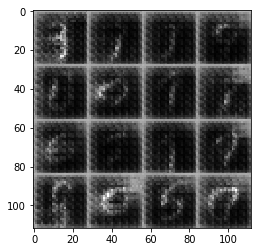

Epoch  1  ... Discri.Loss:  0.411813  Generator loss:  1.62429
Epoch  1  ... Discri.Loss:  0.574902  Generator loss:  3.21856
Epoch  1  ... Discri.Loss:  2.29541  Generator loss:  6.67286
Epoch  1  ... Discri.Loss:  0.245113  Generator loss:  2.60839
Epoch  1  ... Discri.Loss:  0.265611  Generator loss:  2.63163
Epoch  1  ... Discri.Loss:  0.256893  Generator loss:  2.32414
Epoch  1  ... Discri.Loss:  0.359501  Generator loss:  1.83419
Epoch  1  ... Discri.Loss:  0.156751  Generator loss:  2.69217
Epoch  1  ... Discri.Loss:  0.582037  Generator loss:  1.46508
Epoch  1  ... Discri.Loss:  0.285678  Generator loss:  2.20245


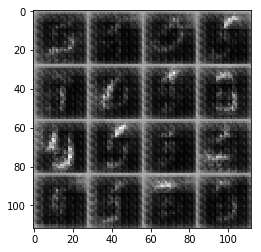

Epoch  1  ... Discri.Loss:  0.183579  Generator loss:  2.65742
Epoch  1  ... Discri.Loss:  0.256128  Generator loss:  2.24024
Epoch  1  ... Discri.Loss:  0.296521  Generator loss:  2.14065
Epoch  1  ... Discri.Loss:  0.298743  Generator loss:  2.16873
Epoch  1  ... Discri.Loss:  0.0599027  Generator loss:  4.32574
Epoch  1  ... Discri.Loss:  0.134072  Generator loss:  3.32924
Epoch  1  ... Discri.Loss:  0.131284  Generator loss:  3.11601
Epoch  1  ... Discri.Loss:  0.211599  Generator loss:  2.68903
Epoch  1  ... Discri.Loss:  0.0998184  Generator loss:  3.48552
Epoch  1  ... Discri.Loss:  0.10252  Generator loss:  3.47119


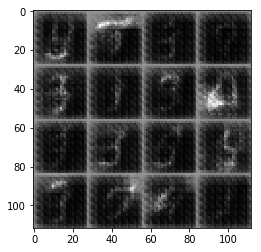

Epoch  1  ... Discri.Loss:  0.110012  Generator loss:  2.67886
Epoch  1  ... Discri.Loss:  0.223057  Generator loss:  2.16651
Epoch  1  ... Discri.Loss:  0.10328  Generator loss:  3.05311
Epoch  1  ... Discri.Loss:  0.117775  Generator loss:  2.94511
Epoch  1  ... Discri.Loss:  0.0975753  Generator loss:  3.26991
Epoch  1  ... Discri.Loss:  0.066383  Generator loss:  4.20767
Epoch  1  ... Discri.Loss:  0.0768293  Generator loss:  3.60626
Epoch  1  ... Discri.Loss:  0.201897  Generator loss:  2.85516
Epoch  1  ... Discri.Loss:  0.104057  Generator loss:  3.40402
Epoch  1  ... Discri.Loss:  0.0752096  Generator loss:  4.26692


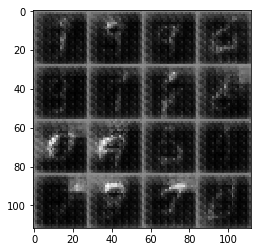

Epoch  1  ... Discri.Loss:  0.0903065  Generator loss:  3.48166
Epoch  1  ... Discri.Loss:  0.0550468  Generator loss:  3.99107
Epoch  1  ... Discri.Loss:  0.130535  Generator loss:  2.89538
Epoch  1  ... Discri.Loss:  0.241848  Generator loss:  2.86992
Epoch  1  ... Discri.Loss:  0.0340081  Generator loss:  4.35646


In [56]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch  0  ... Discri.Loss:  2.08068  Generator loss:  0.311374


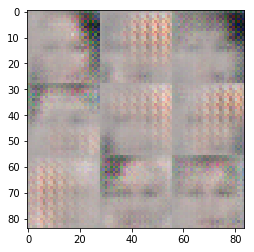

Epoch  0  ... Discri.Loss:  1.78911  Generator loss:  4.50225


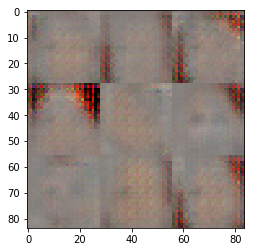

Epoch  0  ... Discri.Loss:  1.14883  Generator loss:  0.999677


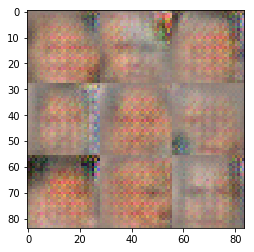

Epoch  0  ... Discri.Loss:  1.14882  Generator loss:  0.787328


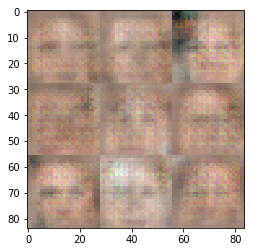

Epoch  0  ... Discri.Loss:  1.18131  Generator loss:  4.95714


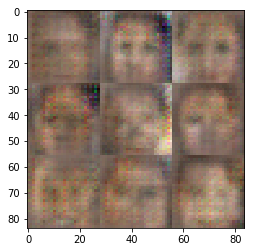

Epoch  0  ... Discri.Loss:  1.31646  Generator loss:  0.668061


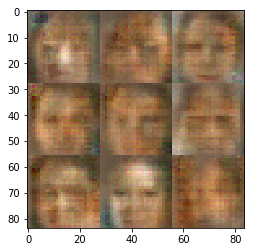

Epoch  0  ... Discri.Loss:  1.30745  Generator loss:  0.971412


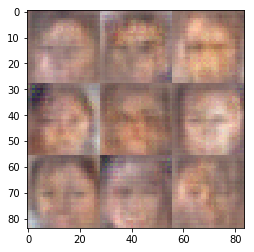

Epoch  0  ... Discri.Loss:  1.30481  Generator loss:  0.848699


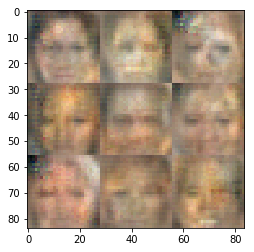

Epoch  0  ... Discri.Loss:  1.26559  Generator loss:  0.623236


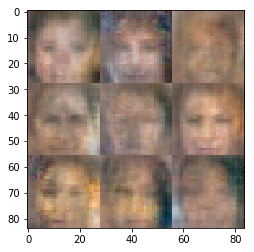

Epoch  0  ... Discri.Loss:  1.11134  Generator loss:  1.0854


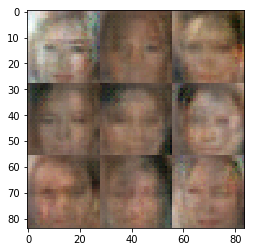

Epoch  0  ... Discri.Loss:  1.24615  Generator loss:  0.768617


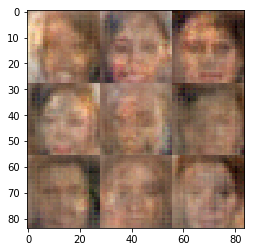

Epoch  0  ... Discri.Loss:  1.33713  Generator loss:  0.860942


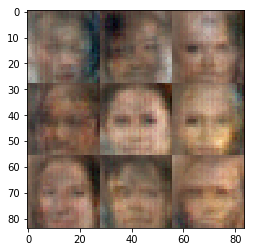

KeyboardInterrupt: 

In [30]:
batch_size = 64
z_dim = 150
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.